# **Exercise session 4: Deep learning algorithms for detecting images from satellite imagery**

Satellite imagery has a strong potential for improving the monitoring of vessel traffic due its global coverage, availability and objectivity. Traditionally, scientists and industry experts in the field have been relying on optical imagery, which is similar to interpreting a photograph (e.g. Sentinel 2 data). Such satellites have wide swath and high resolution but their instruments cannot permeate through the cloud cover. In this exercise, we will build a [Region-based CNN (R-CNN)](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e), an approach introduced in [Girshick et al. (2014)](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Girshick_Rich_Feature_Hierarchies_2014_CVPR_paper.pdf), to detect vessels from optical satellite images. An R-CNN uses algorithms such as Selective Search to divide an image into regions that most likely contain an object and then uses a CNN to extract the features and an SVM to classify the image. There have been several generations of this algorithm, such as Fast R-CNN and Faster R-CNN algorithm.

More recently, data from [Synthetic Aperture Radars (SAR)](https://www.earthdata.nasa.gov/learn/backgrounders/what-is-sar#:~:text=While%20optical%20imagery%20is%20similar,view%20What%20is%20Remote%20Sensing%3F) has become available. The basic idea is that the sensor produces its own active signal and then measures the reflection from the Earth. The benefit of SAR is that the imagery is not affected by clouds, daylight but it is harder to interpret. Such data is available from Sentinel 1. Popular algorithms in vessel detection from SAR-images include constant False-Alarm Rate (CFAR)(see [this github repo for an example of implemention of CFAR](https://github.com/Rc-W024/SAR_Ship_detection_CFAR)) and [Viola & Jones](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf) have been the two most commonly used algorithms in the field due to their accuracy and, in the case of CFAR, high interpretability. However, there is a growing interest in using deep-learning models for vessel detection from SAR images, see [Paolo et al. (2024)](https://doi.org/10.1038/s41586-023-06825-8).

This exercise is designed to be completed on Aalto JupyterHub. Please ensure that your notebook includes all necessary installation commands for any additional libraries your code requires. These commands should be clearly written and integrated within your notebook. To submit, go to Nbgrader/Assignment List and click submit next to the exercise. 
All data loaded from Copernicus Dataspace, should be saved to /coursedata/users/USER folder. Any files that are integral to your submission but cannot be submitted via Nbgrader, should be placed into the /coursedata/users/USER   folder and properly linked to in the notebook.


The deadline is Feb 22 at 10:00. We will be grading the submissions as they arrive, so if you submit before the deadline, you will most likely get feedback earlier.

In [9]:
# Import necessary modules. If any additional modules need to be installed to run it on Aalto JupyterHub, include all necessary installation commands.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, cv2, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *

## Exercise 4.1 Build the R-CNN model (4 pt)

We are going to use R-CNN for vessel detection from optical satellite images. 

1. Train a CNN to classify satellite images. You can use [part I of this tutorial by Gotam Dahiya](https://www.kaggle.com/code/apollo2506/ship-detection-using-faster-r-cnn-part-1) as inpiration or build your own. Feel free to use CNN for feature extraction and SVM for classification or just a CNN for both extraction and classification. You can train the model either directly on Kaggle (or elsewhere) or in JupyterHub. In the former case, upload the model into your /coursedata/users/USER folder. The labelled dataset is available in /coursedata/satellite-imagery-of-ships.

2. Use Selective Search to detect ships from optical scenes using the CNN model you built. You can use [part II of this tutorial by Gotam Dahiya](https://www.kaggle.com/code/apollo2506/ship-detection-using-faster-r-cnn-part-2) as inspiration, but for this part, include complete code implementation here. The labelled dataset is available in /coursedata/satellite-ships-scenes.

## Part I: Train a CNN to classify satellite images

### Disclaimer: most of the code is from the part I kaggle page
### I fix the AUGMENTATION code to fit our case. 

In [63]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass

def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    
#     np.seterr(divide='ignore',invalid='ignore')
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

In [22]:
datasets = ['/coursedata/satellite-imagery-of-ships']

class_names = ["no-ship","ship"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'no-ship': 0, 'ship': 1}

In [37]:
def load_data():
    images, labels = [], []
    
    for dataset in datasets:
        
        for folder in os.listdir(dataset):
            label = class_name_labels[folder]
            folder_path = os.path.join(dataset, folder)
            for file in tqdm(os.listdir(folder_path)):

                # Skip non-image files and directories (including .ipynb_checkpoints)
                if file.startswith('.') or os.path.isdir(os.path.join(folder_path, file)):
                    continue
                    
                img_path = os.path.join(dataset,folder,file)
                img = cv2.imread(img_path)
                
                if img is not None:
                    
                    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (48,48))
                
                images.append(img)
                labels.append(label)
                pass
            pass
        
        images = np.array(images,dtype=np.float32)/255.0
        labels = np.array(labels,dtype=np.float32)
        pass
    
    return (images, labels)
    pass

(images, labels) = load_data()
images.shape, labels.shape

100%|██████████| 563/563 [00:00<00:00, 661.06it/s]


((1388, 48, 48, 3), (1388,))

In [38]:
n_labels = labels.shape[0]

_, count = np.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)
df

Count
Class-Label       
no-ship        826
ship           562

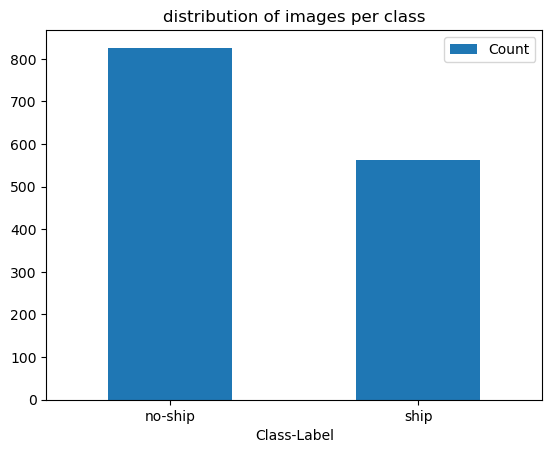

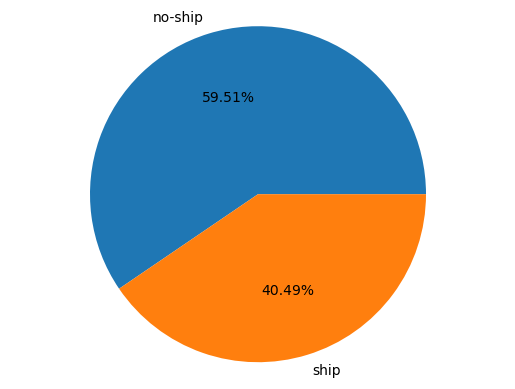

In [39]:
df.plot.bar(rot=0)
plt.title("distribution of images per class");
plt.show()

plt.pie(count,
       explode=(0,0),
       labels=class_names,
       autopct="%1.2f%%")
plt.axis('equal');

Due to imbalance in dataset, upsampling is done on the minority class, by randomly duplicating images until the 2 classes have comparable distribution in the dataset. After this is done, the dataset will be split into the training, testing and validation sets by randomly shuffling them and then splitting.

Another way is to introduce class weights for each specific class. Each class is penalised with the specific class weight. Higher the class weight, greater the penalty. Classes with lower percentage have a higher penalty. This allows for the model to penalise itself heavily if class detected is incorrect.

In [41]:
_, count = np.unique(labels, return_counts=True)
print(count)

[826 562]


In [49]:
AUGMENTATION = True


def augment_add(images, seq, labels, count):
    difference_num_images = np.abs(count[0] - count[1])
    augmented_images, augmented_labels = [],[]
    
    if difference_num_images < np.min(np.array(count)):
        number_of_rounds = 1
    else:
        number_of_rounds = difference_num_images // np.min(np.array(count))
    
    for i in range(number_of_rounds):
        if count[0] > count[1]:
            for idx,img in tqdm(enumerate(images)):
                if labels[idx] == 1:
                    image_aug_1 = seq.augment_image(image=img)
                    #image_aug_2 = seq.augment_image(image=img)
                    augmented_images.append(image_aug_1)
                    #augmented_images.append(image_aug_2)
                    augmented_labels.append(labels[idx])
                    #augmented_labels.append(labels[idx])
                pass
        if count[1] > count[0]:
            for idx,img in tqdm(enumerate(images)):
                if labels[idx] == 0:
                    image_aug_1 = seq.augment_image(image=img)
                    #image_aug_2 = seq.augment_image(image=img)
                    augmented_images.append(image_aug_1)
                    #augmented_images.append(image_aug_2)
                    augmented_labels.append(labels[idx])
                    #augmented_labels.append(labels[idx])
                pass
    
    augmented_images = np.array(augmented_images[:difference_num_images], dtype=np.float32)
    augmented_labels = np.array(augmented_labels[:difference_num_images], dtype=np.float32)
    
    return (augmented_images, augmented_labels)
    pass

seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    #iaa.Crop(percent=(0,0.1)),
    iaa.LinearContrast((0.75,1.5)),
    iaa.Multiply((0.8,1.2), per_channel=0.2),
    iaa.Affine(
        scale={'x':(0.8,1.2), "y":(0.8,1.2)},
        translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)},
        rotate=(-25,25),
        shear=(-8,8)
    )
], random_order=True)

if AUGMENTATION:
    (aug_images, aug_labels) = augment_add(images, seq, labels, count)
    images = np.concatenate([images, aug_images])
    labels = np.concatenate([labels, aug_labels])
    
images.shape, labels.shape

1388it [00:00, 2551.71it/s]


((1652, 48, 48, 3), (1652,))

(1652, 48, 48, 3) (1652,)


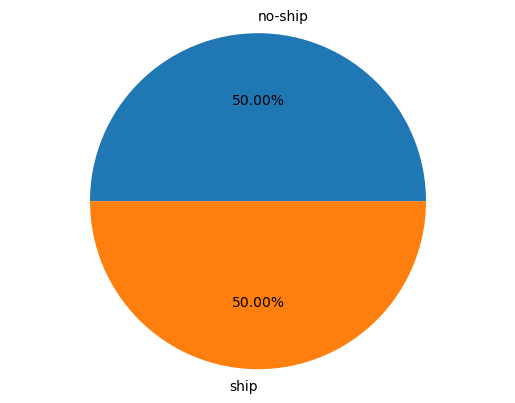

In [51]:
if AUGMENTATION:
    _, count = np.unique(labels, return_counts=True)

    plt.pie(count,
           explode=(0,0),
           labels=class_names,
           autopct="%1.2f%%")
    plt.axis('equal');
    
print(images.shape, labels.shape)

One Hot Encoding Variables

The labels numpy array is one hot encoded using to_categorical from keras. This removes any uncessary bias in the dataset, by keeping the class at equal footing, with respect to labels.

In [52]:
labels = to_categorical(labels)

Training, Validation and Testing
Instead of using train_test_split the images and labels arrays are randomly shuffled using the same seed value set at 42. This allows the images and their corresponding labels to remain linked even after shuffling.

This method allows the user to make all 3 datasets. The training and validation dataset is used for training the model while the testing dataset is used for testing the model on unseen data. Unseen data is used for simulating real-world prediction, as the model has not seen this data before. It allows the developers to see how robust the model is.

Spliting of data
70% - Training
20% - Validation
10% - Testing

In [54]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

total_count = len(images)
total_count

train = int(0.7*total_count)
val = int(0.2*total_count)
test = int(0.1*total_count)

train_images, train_labels = images[:train], labels[:train]
val_images, val_labels = images[train:(val+train)], labels[train:(val+train)]
test_images, test_labels = images[-test:], labels[-test:]

train_images.shape, val_images.shape, test_images.shape

((1156, 48, 48, 3), (330, 48, 48, 3), (165, 48, 48, 3))

In [55]:
if not AUGMENTATION:
    count_labels = train_labels.sum(axis=0)

    classTotals = train_labels.sum(axis=0)
    classWeight = {}

    for i in range(0,len(classTotals)):
        classWeight[i] = classTotals.max()/classTotals[i]
        pass
    print(classWeight)

Creation of model

conv_block - This function contains the convulotional layer, batch normalization and activation layers. The number of filters, kernel_size, strides to be taken are defined by the developer. This allows a developer to make the model without having to repeat the same lines continuously many times. It also uses the OOPs concepts of Python which is recommended instead of coding like it is C.

basic_model - This function creates the model using the aforementioned function, max pooling layers and dropouts. After the specified number of convolutional layers, a flatten layer is introduced, along with dense layers so that the image can be classified. The flatten layer converts the feature map produced by the convolutional layers into a single column for classification.

For image detection in images using Faster R-CNN the feature map produced by the convolutional layers is used, i.e., the model drops the layers after the final convolutional block and passes the generated feature map to a Regional Proposal Network, which can either uses a vanilla CNN model containing fully connected layers or a Logistic Regression, Support Vector machines or Random forests. Advised to use vanilla CNN as it uses less CPU and memory, plus slightly faster and capable of giving multiple outputs if required.

In [56]:
def conv_block(X,k,filters,stage,block,s=2):
    
    conv_base_name = 'conv_' + str(stage)+block+'_branch'
    bn_base_name = 'bn_'+str(stage)+block+"_branch"
    
    F1 = filters
    
    X = Conv2D(filters=F1, kernel_size=(k,k), strides=(s,s),
              padding='same',name=conv_base_name+'2a')(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation('relu')(X)
    
    return X
    pass

def basic_model(input_shape,classes):
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((5,5))(X_input)
    
    X = Conv2D(16,(3,3),strides=(2,2),name='conv1',padding="same")(X)
    X = BatchNormalization(name='bn_conv1')(X)
    
    # stage 2
    X = conv_block(X,3,32,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 3
    X = conv_block(X,5,32,3,block='A',s=2)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)
    
#     Stage 4
    X = conv_block(X,3,64,4,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)
    
#   Output Layer
    X = Flatten()(X)
    X = Dense(64)(X)
    X = Dropout(0.5)(X)
    
    X = Dense(128)(X)
    X = Activation("relu")(X)
    
    X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)
    
    model = Model(inputs=X_input,outputs=X,name='Feature_Extraction_and_FC')
    
    return model
    pass

In [57]:
model = basic_model(input_shape=(48,48,3),classes=2)
plot_model(model,to_file='basic_model.png')
SVG(model_to_dot(model).create(prog='dot',format='svg'))

model.summary()

Model: "Feature_Extraction_and_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 58, 58, 3)         0         
 g2D)                                                            
                                                                 
 conv1 (Conv2D)              (None, 29, 29, 16)        448       
                                                                 
 bn_conv1 (BatchNormalizati  (None, 29, 29, 16)        64        
 on)                                                             
                                                                 
 conv_2A_branch2a (Conv2D)   (None, 29, 29, 32)        4640      
                                                                 
 bn_2A_branch2a (BatchNorma  (None, 29, 2

Compiling the Model

The model is compiled using the Adam optimizer with learning rate set at 1e-3. Binary Crossentropy is used as a loss function as there are only two classes.

In [58]:
opt = Adam(lr=1e-3)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")

Training model

The model is trained for 50 epochs with a batch size of 16. The best model weights are stored in the file model_weight.h5 with TensorBoard logs being stored in the logs directory.

In [59]:
epochs = 50
batch_size = 16

history = model.fit(train_images,train_labels,
                   steps_per_epoch=len(train_images)//batch_size,
                   epochs=epochs,
                   verbose=1, 
                   validation_data=(val_images,val_labels),
                   validation_steps=len(val_images)//batch_size,
                   callbacks=[checkpoint, logs]
#                    class_weight=classWeight # Uncomment if AUGMENTATION is set to FALSE
                   )

Epoch 1/50
72/72 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.6920
Epoch 1: val_accuracy improved from -inf to 0.82727, saving model to model_weights.h5
72/72 [==============================] - 5s 51ms/step - loss: 0.6131 - accuracy: 0.6920 - val_loss: 0.5793 - val_accuracy: 0.8273
Epoch 2/50
 3/72 [>.............................] - ETA: 2s - loss: 0.3968 - accuracy: 0.8235

/opt/software/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - ETA: 0s - loss: 0.3568 - accuracy: 0.8472
Epoch 2: val_accuracy did not improve from 0.82727
72/72 [==============================] - 4s 58ms/step - loss: 0.3568 - accuracy: 0.8472 - val_loss: 0.5470 - val_accuracy: 0.6879
Epoch 3/50
71/72 [============================>.] - ETA: 0s - loss: 0.2613 - accuracy: 0.9014
Epoch 3: val_accuracy did not improve from 0.82727
72/72 [==============================] - 3s 48ms/step - loss: 0.2594 - accuracy: 0.9028 - val_loss: 0.4474 - val_accuracy: 0.7515
Epoch 4/50
72/72 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9199
Epoch 4: val_accuracy did not improve from 0.82727
72/72 [==============================] - 3s 47ms/step - loss: 0.1939 - accuracy: 0.9199 - val_loss: 0.3545 - val_accuracy: 0.8273
Epoch 5/50
72/72 [==============================] - ETA: 0s - loss: 0.1632 - accuracy: 0.9346
Epoch 5: val_accuracy improved from 0.82727 to 0.87879, saving model to model_weights.h5
72/


Epoch 48: val_accuracy did not improve from 0.98788
72/72 [==============================] - 1s 11ms/step - loss: 0.0111 - accuracy: 0.9926 - val_loss: 0.1159 - val_accuracy: 0.9848


Plotting Loss and Accuracy

The loss and accuracy for the training and validation datasets is plotted using the show_final_history function

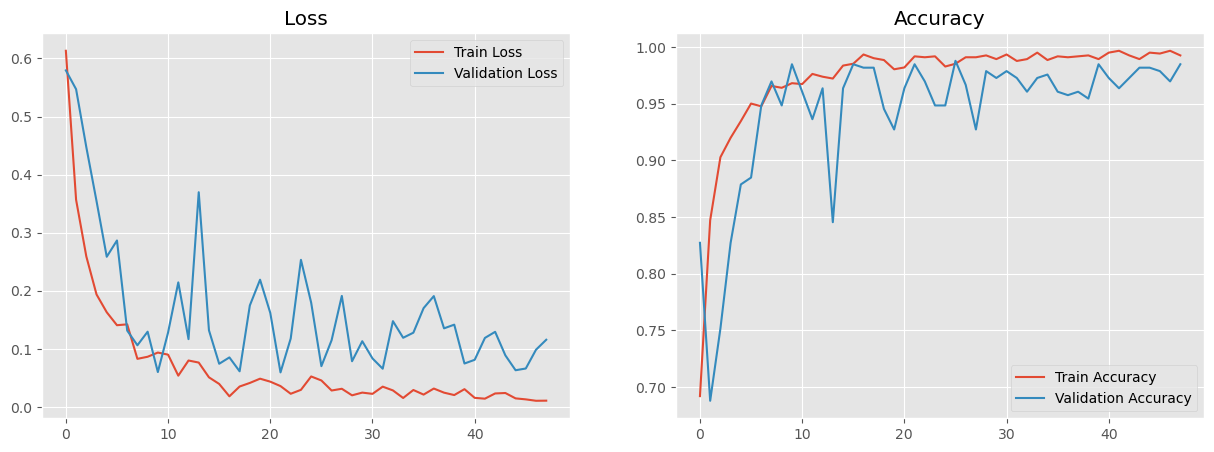

In [60]:
show_final_history(history)

Confusion Matrix for Validation dataset

The confusion matrix

In [61]:
val_pred = model.predict(val_images)
val_pred = np.argmax(val_pred,axis=1)
val_pred.shape

11/11 [==============================] - 0s 13ms/step


(330,)

<Figure size 640x480 with 0 Axes>

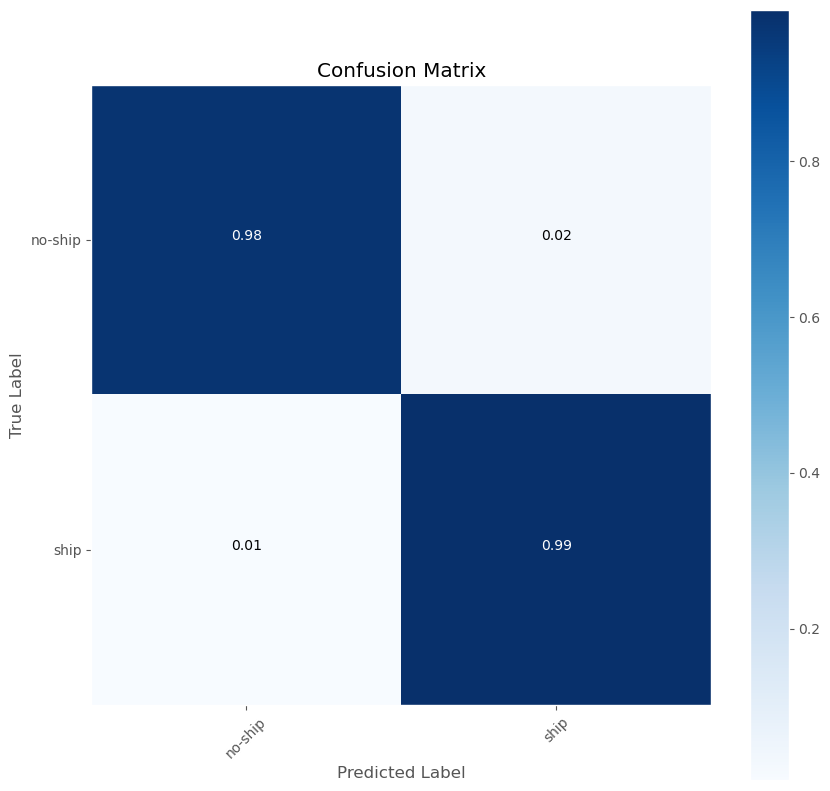

In [64]:
val_actual = np.argmax(val_labels,axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.grid(None)
plt.show();

Confusion Matrix for Testing Dataset

In [65]:
test_pred = model.predict(test_images)
test_pred = np.argmax(test_pred,axis=1)
test_pred.shape

6/6 [==============================] - 0s 16ms/step


(165,)

<Figure size 640x480 with 0 Axes>

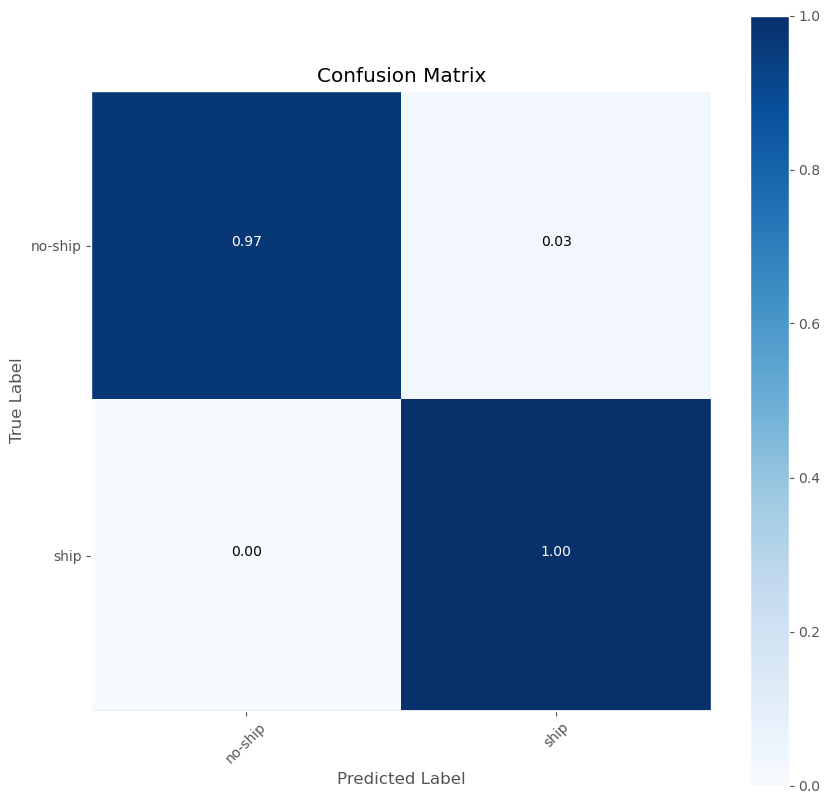

In [66]:
test_actual = np.argmax(test_labels,axis=1)

cnf_mat_test = confusion_matrix(test_actual, test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat_test,classes=class_names)
plt.grid(None)
plt.show()

### Checking the model

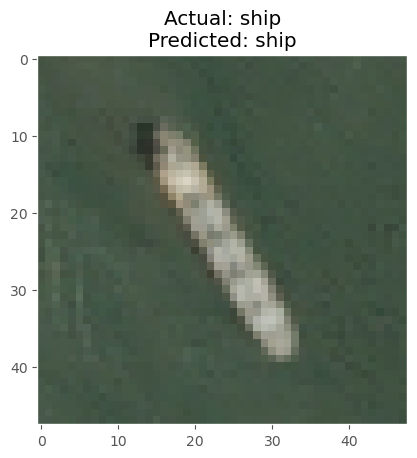

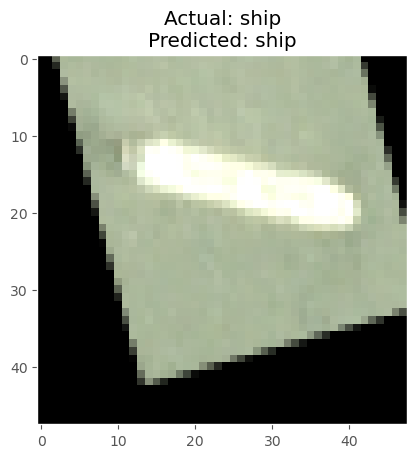

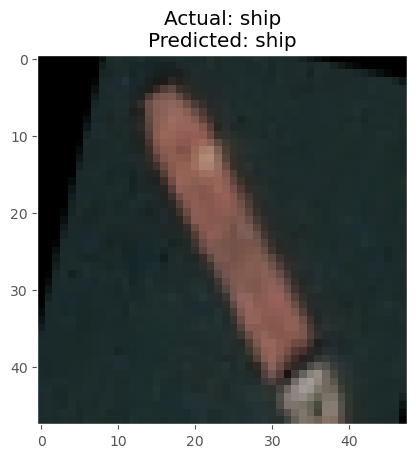

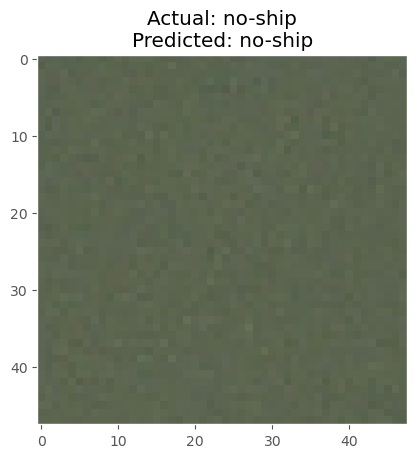

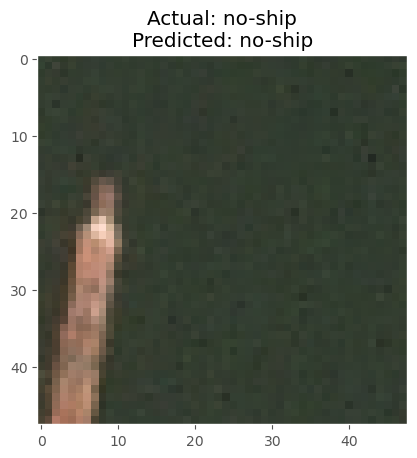

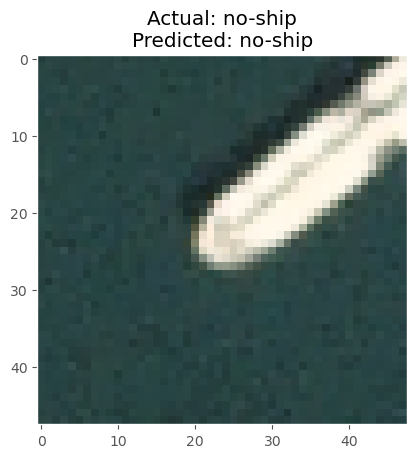

In [70]:
rnd_idx = random.sample(range(0,100), 6)

class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
class_labels

# fig, ax = plt.subplots(2,5,figsize=(5,5))

for i,idx in enumerate(rnd_idx):
    
    plt.imshow(test_images[idx])
    plt.title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]],class_labels[test_pred[idx]]))
    plt.grid(None)
    plt.show()
    pass

In [72]:
### Saving the model

model.save("CNN-ship-model.keras")

## Part II: Use Selective Search to detect ships from optical scenes using the CNN model built above

### Disclaimer: most of the code is from the part II kaggle page

In [11]:
# Installing opencv-contrib as SelectiveSearch Algorithm is still not part of the official package
!pip uninstall -y opencv-python
!pip3 install opencv-contrib-python
# Installing imutils for non-max suppression libraries
!pip3 install imutils

Found existing installation: opencv-python 4.8.1
ERROR: Cannot uninstall opencv-python 4.8.1, RECORD file not found. Hint: The package was installed by conda.


In [6]:
import numpy as np 
import pandas as pd 
import cv2, os, re
import matplotlib.pyplot as plt
import imutils

from tqdm import tqdm
from imutils.object_detection import non_max_suppression

from tensorflow.keras.models import load_model

Utitilty Functions

find_regions: This method is used for finding Region of Interests(ROI) using the Selective Search Algorithm. There are 2 methods, fast and quality. The fast methods finds the ROI faster but with lesser quality, whie the quality finds more ROI at a cost of more time spent

load_scenes: Load the geospatial images into a list for object detection.

In [3]:
def find_regions(image, method):
    
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    
    if method == 'fast':
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()
    
    rects = ss.process()
    boxes = []
    for (x,y,w,h) in rects:
        
        boxes.append([x,y,w,h])
        pass
    
    return boxes
    pass

In [4]:
scene_path = '/coursedata/satellite-ships-scenes'

def load_scenes():
    
    scenes = []
    dirfiles = os.listdir(scene_path)
    dirfiles = sorted(dirfiles)
    
    for file in dirfiles:
        folder_path = os.path.join(scene_path, file)
        print(folder_path)
        # Skip non-image files and directories (including .ipynb_checkpoints)
        if file.startswith('.') or os.path.isdir(folder_path):
            continue
                    
        scene = cv2.imread(os.path.join(scene_path, file))
        if scene is not None:
            scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
            scenes.append(scene)
        pass
    
    return scenes
    pass

scenes = load_scenes()

/coursedata/satellite-ships-scenes/.ipynb_checkpoints
/coursedata/satellite-ships-scenes/lb_1.png
/coursedata/satellite-ships-scenes/lb_2.png
/coursedata/satellite-ships-scenes/lb_3.png
/coursedata/satellite-ships-scenes/lb_4.png
/coursedata/satellite-ships-scenes/sfbay_1.png
/coursedata/satellite-ships-scenes/sfbay_2.png
/coursedata/satellite-ships-scenes/sfbay_3.png
/coursedata/satellite-ships-scenes/sfbay_4.png


To change the type of detection, change the method variable. Options:
- fast
- quality

In [ ]:
%%time
method = "fast"

boxes = []

for scene in scenes:
    
    box_in_scene = find_regions(scene, method)
    boxes.append(box_in_scene)
    pass

Loading Saved Model

The model trained in Ship Detection using Faster R-CNN: Part 1 on the dataset is loaded along with the weights obtained from the model. The current model is based upon the class weights. For the model based upon augmentation, Part 1 will have to be run with AUGMENTATION set to True.

In [85]:
model = load_model('CNN-ship-model.keras')

model.summary()

Model: "Feature_Extraction_and_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 58, 58, 3)         0         
 g2D)                                                            
                                                                 
 conv1 (Conv2D)              (None, 29, 29, 16)        448       
                                                                 
 bn_conv1 (BatchNormalizati  (None, 29, 29, 16)        64        
 on)                                                             
                                                                 
 conv_2A_branch2a (Conv2D)   (None, 29, 29, 32)        4640      
                                                                 
 bn_2A_branch2a (BatchNorma  (None, 29, 2

Predicting the ROIs

The ROIs for each scene are taken and run through the model. ROIs with scaling factor greater than 0.10 are ignored as they are to be big for the and lead to uncessary ROIs being predicted. The scaling factor in an ideal situation should vary between 0.10 and 0.15, as they are the sweet spots, where a ship inside a ROI but not an entire city block.

Bounding boxes are drawn around each detected object if it is classified as a ship, otherwise not. The resulting images are stored in the images list for displaying.

In [ ]:
%%time

rois, locs = [], []
images = []
for i,scene in tqdm(enumerate(scenes)):
    
    (H, W) = scene.shape[:2]
    region, loc = [],[]
    for (x,y,w,h) in boxes[i]:

        if w/float(W) > 0.10 and h/float(H) > 0.10:
            continue

        roi = scene[y:y+h,x:x+w]
        roi = cv2.cvtColor(roi,cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, (48,48))

        rois.append(roi)
        locs.append((x,y,x+w,y+h))
        pass
    
    preds = model.predict(np.array(rois,dtype=np.float32))
    preds = np.argmax(preds, axis=1)
    
    img = scene.copy()
    for (i,label) in enumerate(preds):

        if label == 1:
            (startX,startY,endX,endY) = locs[i]
            cv2.rectangle(img,(startX,startY),(endX,endY),(0,255,0),2)
        pass
    
    images.append(img)
    del rois[:]
    del locs[:]
    pass

Displaying final Images

The final images containing the predicted bounding boxes are displayed in the next code block.

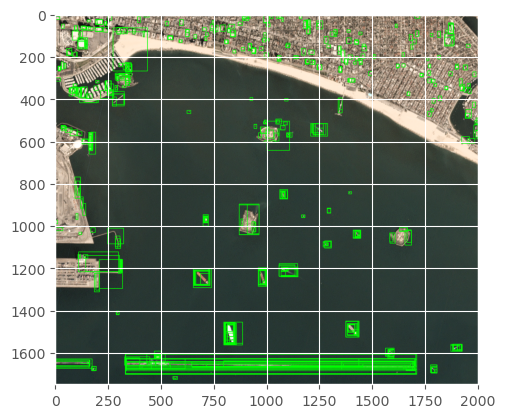

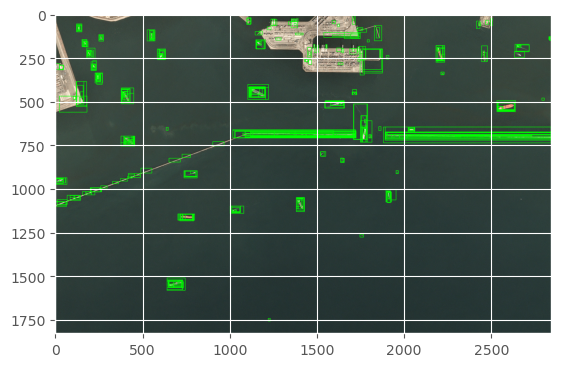

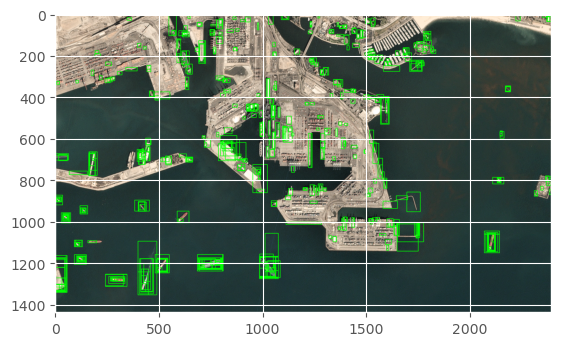

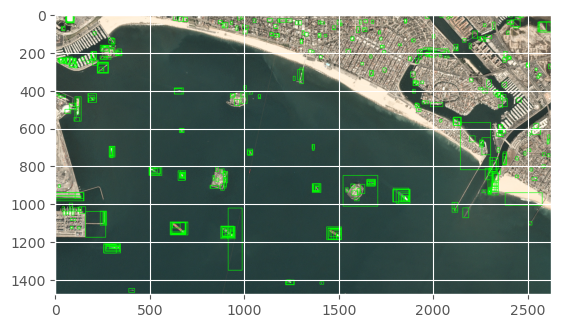

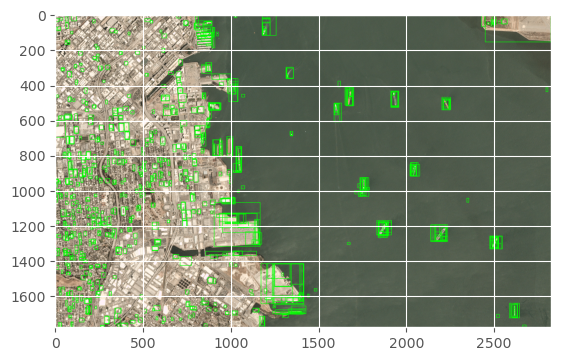

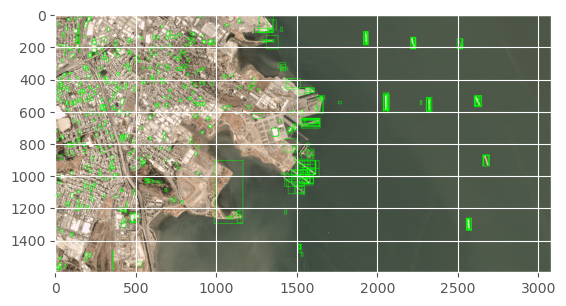

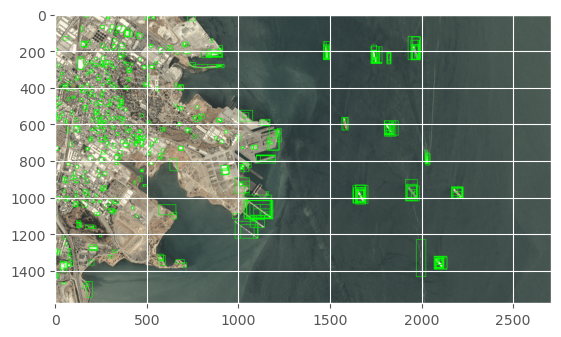

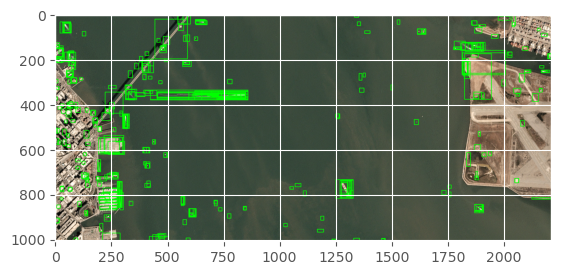

In [88]:
for image in images:
    
    plt.imshow(image)
    plt.show();

## Exercise 4.2 Test your model on real data (3 pt)

Pick an area (Paolo et al (2024) can be useful here), make 5 scenes from Sentinel 2 data and test your algorithm on the data.

I make 5 scenes in total from the Copernicus Browser, whose ports are the busiest in the world

- Rotterdam Port.png
- Shanghai Port.png
- Shenzhen Port.png
- Singapore Port.png
- Tanjung Priok Port.png


In [12]:
scene_path = '/coursedata/users/nguyenb5/sentinel2_L2A_scenes'

scenes = load_scenes()

method = "fast"

boxes = []

for scene in scenes:
    
    box_in_scene = find_regions(scene, method)
    boxes.append(box_in_scene)
    pass

model = load_model('CNN-ship-model.keras')

rois, locs = [], []
images = []
for i,scene in tqdm(enumerate(scenes)):
    
    (H, W) = scene.shape[:2]
    region, loc = [],[]
    for (x,y,w,h) in boxes[i]:

        if w/float(W) > 0.10 and h/float(H) > 0.10:
            continue

        roi = scene[y:y+h,x:x+w]
        roi = cv2.cvtColor(roi,cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, (48,48))

        rois.append(roi)
        locs.append((x,y,x+w,y+h))
        pass
    
    preds = model.predict(np.array(rois,dtype=np.float32))
    preds = np.argmax(preds, axis=1)
    
    img = scene.copy()
    for (i,label) in enumerate(preds):

        if label == 1:
            (startX,startY,endX,endY) = locs[i]
            cv2.rectangle(img,(startX,startY),(endX,endY),(0,255,0),2)
        pass
    
    images.append(img)
    del rois[:]
    del locs[:]
    pass

/coursedata/users/nguyenb5/sentinel2_L2A_scenes/.ipynb_checkpoints
/coursedata/users/nguyenb5/sentinel2_L2A_scenes/Rotterdam Port.png
/coursedata/users/nguyenb5/sentinel2_L2A_scenes/Shanghai Port.png
/coursedata/users/nguyenb5/sentinel2_L2A_scenes/Shenzhen Port.png
/coursedata/users/nguyenb5/sentinel2_L2A_scenes/Singapore Port.png
/coursedata/users/nguyenb5/sentinel2_L2A_scenes/Tanjung Priok Port.png


0it [00:00, ?it/s]

431/431 [==============================] - 7s 14ms/step


1it [00:07,  7.25s/it]

73/73 [==============================] - 1s 13ms/step


2it [00:08,  3.63s/it]

234/234 [==============================] - 4s 18ms/step


3it [00:13,  4.10s/it]

30/30 [==============================] - 1s 17ms/step


4it [00:13,  2.73s/it]

76/76 [==============================] - 1s 14ms/step


5it [00:14,  2.97s/it]


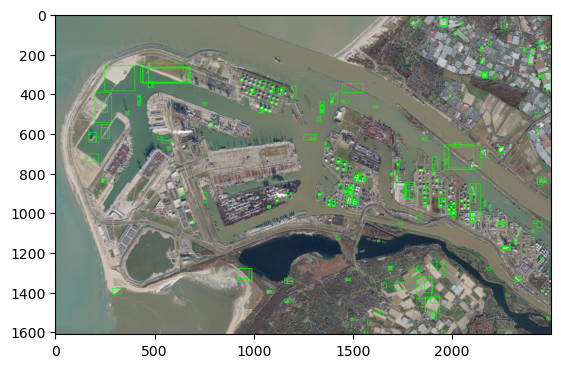

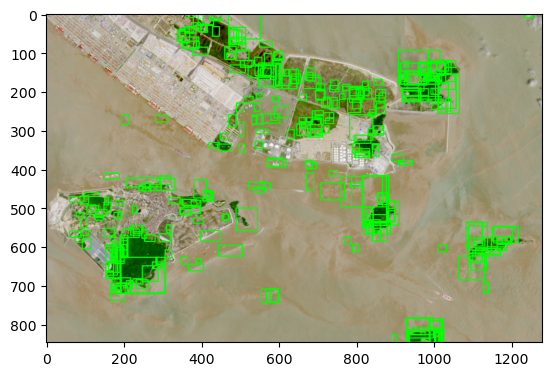

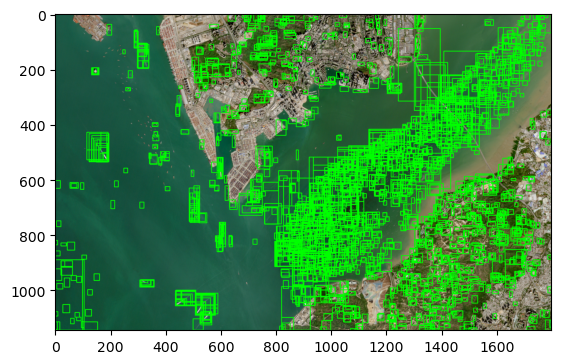

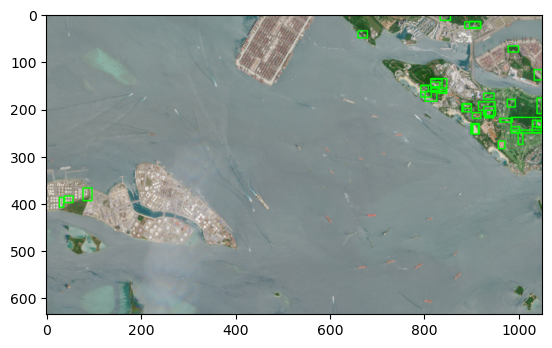

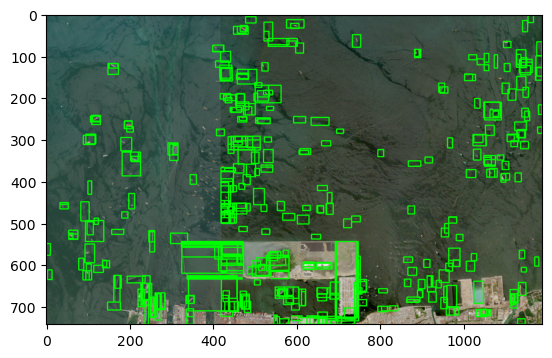

In [13]:
for image in images:
    
    plt.imshow(image)
    plt.show();

Conclusion: The CNN base model is not working properly. It has a lot of false positive detections

## Exercise 4.3 Uncertainty of the model in Exercises 4.1-2 (3 pt)

One concern of using machine learning methods is how to [understand and quantify uncertainty](https://arxiv.org/pdf/2107.03342.pdf). In the case of the model in Ex. 4.1-4.2 uncertainty could come from:
- data acquisition, such as the ability of the labelled data to capture the variability of the real world data and possible errors and noise in the images;
- design and training, such as errors in model structure and training procedure;
- inference, how well the training data (=Ex. 4.1) matches the real world data where the model is applied (e.g., in Ex. 4.2).

Discuss uncertainty in the model from Ex. 4.1-2 and possible solutions to decrease it.

In order to resolve uncertainty in Exercises 4.1-2:

- Uncertainty in data acquisition: Improve data representation by adding more conditions and expanding the dataset. To boost image quality, we apply noise reduction and image enhancement techniques.

- Design and training uncertainty: Make use of architectures that have been shown to work well for similar tasks, including regularization strategies to avoid overfitting, and make sure full validation is performed on a variety of datasets. To improve the quantification of uncertainty, we can investigate ensemble methods or Bayesian methodologies.

- Inference uncertainty: Keep the model updated with recent real-world data to close the gap between training and real-world scenarios. We can use methods such as Monte Carlo Dropout to estimate uncertainty at runtime.

## Exercise 4.5 Compare the approach you took in Ex. 4.1-2 to Paolo et al (2024) (3 pt)

Using R-CNN and Faster R-CNN models for the particular goal of identifying ships in satellite photos is the main emphasis of exercises 4.1 and 4.2. There are two main steps in this process: first, a Convolutional Neural Network (CNN) is trained to identify whether or not images contain ships, and then, a method such as Region Proposal Networks (RPNs) or Selective Search is used to identify regions within the images that are likely to contain ships. The goal of data augmentation approaches is to improve the model's ability to generalize from training data to real-world events. One example of this is to artificially increase the diversity of ship photos in the training dataset. This method is technical and focuses on optimizing the accuracy and computing efficiency of the model.


Paolo et al.'s study from 2024, in comparison, looks at a wider range of satellite-based maritime activity monitoring, including ship identification. In order to understand industrial activity at sea, such as shipping lanes, port operations, and maybe illicit fishing or pollution, their job involves an examination of satellite imagery. The methodology of Paolo may combine various satellite data sources and analytical methods to provide a comprehensive view of marine activities with a focus on the consequences for the environment, regulations, and policy. This might use machine learning models similar to those in Exercises 4.1 and 4.2, but it would be a component of a bigger framework meant to solve more general maritime issues.

## Exercise 4.6 Mapping vessel traffic and climate action (3 pt)
Why is mapping of vessel traffic relevant for climate action? How could you use such maps for tracking greenhouse gas emissions? 

Vessel traffic mapping is essential for climate action because it enables us to monitor the maritime activities, which contributes a lot to greenhouse gas emissions. Researchers may find out key shipping lanes and ports with lots of activity by accurately tracking the movements and density of ships across the world. This helps them select regions where emissions reductions could be most plausible. Additionally, by obtaining data of fuel use and shipping efficiency, it can give us knowledge of the environmental effects of the maritime industry. Vessel traffic maps can also be used to identify illegal operations, including fishing without permission or avoiding emission control zones, that result in greenhouse gas emissions.

## Exercise 4.7 (Optional) R-CNN for detecting vessel traffic from SAR images (10 bonus pts)

Similar to Ex. 4.1, build a R-CNN to detect vessel traffic from SAR images. You can use any of the datasets listed [here](https://github.com/jasonmanesis/Satellite-Imagery-Datasets-Containing-Ships) and also take inspiration from [this code implementation](https://github.com/jasonmanesis/Ship-Detection-on-Remote-Sensing-Synthetic-Aperture-Radar-Data?tab=readme-ov-file). Note that those SAR datasets contain scenes with metafiles identifying the precise location of vessels, so you would need to use this meta data to produce your own labelled dataset for training the classifier. Compare your results to the model from Ex. 4.1.